In [2]:
# !pip install git+https://github.com/crispitagorico/sigkernel.git
# !git clone 'https://github.com/ryanmccrickerd/rough_bergomi.git'

In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns

from fBM import fBM_analytic_pricer, fBM_MC_pricer, fBM_sigkernel_pricer
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [208]:
# model parameters
T, a         = 1., -0.4
n_increments = 10

# payoffs
# payoff_type = 'Identity'
payoff_type = 'Exponential'
# payoff_type = 'Call'

nu = 2e-1
log_strike = -2
if payoff_type == 'Identity':
    payoff = lambda x: x
if payoff_type == 'Exponential': 
    payoff = lambda x: np.exp(nu*x) 
if payoff_type == 'Call': 
    payoff = lambda x: max(x - log_strike, 0.) # call 

# evaluation points
n_eval       = 100
# t_inds_eval  = np.random.choice([n_increments-1, n_increments], n_eval)
# t_inds_eval = np.random.choice(np.arange(1,n_increments), n_eval)
t_inds_eval  = np.random.choice(n_increments, n_eval)
paths_eval   = generate_theta_paths(t_inds_eval, n_increments, T, a)

In [209]:
grid = np.linspace(0, T, 1+n_increments)
true_prices = fBM_analytic_pricer(t_inds_eval, paths_eval, grid, a, T, nu, log_strike, payoff_type=payoff_type)

In [210]:
# sigkernel PDE computation params
dyadic_order, max_batch = 1, 200

In [211]:
m, n = 100, 100

# sigmas_t   = [1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6]
# sigmas_sig = sigmas_t

# mse_score = 1e5
# for sigma_t in sigmas_t:
#     for sigma_sig in sigmas_sig:

#         sig_ptight_layoutr = fBM_sigkernel_pricer(n_increments, m, n, T, a, sigma_t, sigma_sig, dyadic_order, max_batch, device)
#         sig_pricer.fit(payoff)
#         sig_prices = sig_pricer.predict(t_inds_eval, paths_eval) 

#         mse_score_pred = error_fn(true_prices, sig_prices)

#         if mse_score_pred < mse_score: 
#             print(f'sigma_t: {sigma_t}, sigma_sig: {sigma_sig}, MSE: {mse_score_pred}')
#             mse_score = mse_score_pred
#             sigma_t_best, sigma_sig_best = sigma_t, sigma_sig

In [215]:
m, n = 200, 200
sigma_t_best, sigma_sig_best = 1e2, 1e5

In [216]:
sig_pricer = fBM_sigkernel_pricer(n_increments, m, n, T, a, sigma_t_best, sigma_sig_best, dyadic_order, max_batch, device)
sig_pricer.fit(payoff)
sig_prices = sig_pricer.predict(t_inds_eval, paths_eval)
r2_score  = r2(true_prices, sig_prices)
mse_error = mse(true_prices, sig_prices)
mae_error = mae(true_prices, sig_prices)

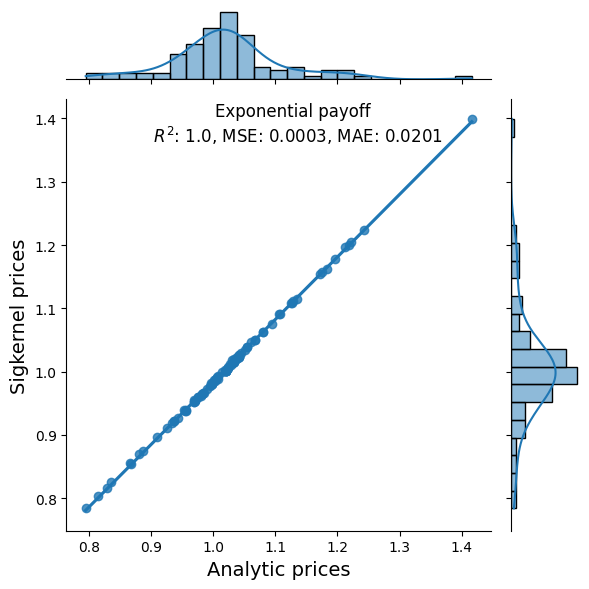

In [217]:
p = sns.jointplot(x=true_prices, y=sig_prices, kind='reg')
p.set_axis_labels('Analytic prices', 'Sigkernel prices', fontsize=14)
p.fig.suptitle(payoff_type + f" payoff \n $R^2$: {np.round(r2_score, 3)}, MSE: {np.round(mse_error, 4)}, MAE: {np.round(mae_error, 4)}", y = 0.82)
p.figure.tight_layout()
plt.savefig('figures/fBM_' + payoff_type)
plt.show()

In [197]:
# precisions = [1e-2, 1e-3, 1e-4, 5e-5, 2e-5]

# n_samples_mc, error_mc = 0, 1e9
# m, n, error_sig        = 0, 0, 1e9

# for precision in precisions:

#     # MC prices
#     while error_mc > precision:
#         n_samples_mc += 10
#         mc_pricer = fBM_MC_pricer(n_increments, n_samples_mc, T, a)
#         t0 = time.time()
#         mc_prices = mc_pricer.fit_predict(t_inds_eval, paths_eval, payoff)
#         t1 = time.time()
#         error_mc  = mse(mc_prices, true_prices)

#     print('Monte Carlo | %2.5f | sample paths: %r | time: %2.4f sec' % (precision, n_samples_mc, t1-t0))
    
#     # PPDE prices
#     while error_sig > precision:
#         m += 10
#         n += 10
#         # print(m,n)
#         sig_pricer = fBM_sigkernel_pricer(n_increments, m, n, T, a, sigma_t_best, sigma_sig_best, dyadic_order, max_batch, device)
#         sig_pricer.fit(payoff)
#         t0 = time.time()
#         sig_prices = sig_pricer.predict(t_inds_eval, paths_eval) 
#         t1 = time.time()
#         error_sig = mse(sig_prices, true_prices)
#         torch.cuda.empty_cache()

#     print('PPDE (sigkernel) | %2.5f | collocation points: (%r,%r) | time: %2.4f sec \n' % (precision, m, n, (t1-t0)/2))
